In [1]:
%matplotlib inline

In [39]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score
from scipy.stats import chi2_contingency
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import codecs
import glob

In [3]:
def get_distribution(dataframe, key='title'):
    words = []
    for row in dataframe[key].apply(lambda x: x.split()).ravel():
        words.extend(row)
    return FreqDist(words)

In [4]:
train_classes = pd.DataFrame.from_csv('train_classes.txt')
dev_classes = pd.DataFrame.from_csv('dev_classes.txt')

In [5]:
dfs = []
for f in glob.glob('tokens?.txt'):
    df = pd.read_csv(f, index_col=None, sep='\t', header=None, names=['post_id', 'title', 'doc'])
    dfs.append(df)
df = pd.concat(dfs)

In [6]:
labeled_docs = df.merge(train_classes, on='post_id').replace(np.nan, '', regex=True)
positives = labeled_docs[labeled_docs['class'] == False]
controls = labeled_docs[labeled_docs['class'] == True]

In [7]:
test_docs = df.merge(dev_classes, on='post_id').replace(np.nan, '', regex=True)

In [15]:
expected_dist = get_distribution(labeled_docs, key='title')
positive_dist = get_distribution(positives, key='title')
controls_dist = get_distribution(controls, key='title')

In [16]:
values = []
for word, count in positive_dist.most_common():
    if count < 50 or 1. * count / len(positives) > 0.4: continue
        
    obs = np.array([
        [positive_dist[word], positive_dist.N()-positive_dist[word]],
        [controls_dist[word], controls_dist.N()-controls_dist[word]]
    ])
    g, p, _, _ = chi2_contingency(obs, lambda_='log-likelihood')
    values.append((word, g))

values = sorted(values, key=lambda x: x[1], reverse=True)

In [8]:
vectorizer = CountVectorizer(
    tokenizer=lambda x: x.split(), 
    stop_words='english', 
    decode_error='ignore', 
    min_df=40
)

In [9]:
vectorizer.fit(labeled_docs.title)
vocab = vectorizer.transform(labeled_docs.title)
test = vectorizer.transform(test_docs.title)

In [49]:
#clf = MultinomialNB()
clf = RandomForestClassifier(n_estimators=15, max_depth=30)

In [50]:
clf.fit(vocab, labeled_docs['class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [51]:
labels = clf.predict_proba(test)

In [52]:
accuracy_score(test_docs['class'].as_matrix().astype('float'), np.argmax(labels, axis=1))

0.73142611708724836

In [53]:
true = test_docs['class'].as_matrix().astype('float')

In [54]:
fpr, tpr, thresholds = roc_curve(true, labels[:, 1])

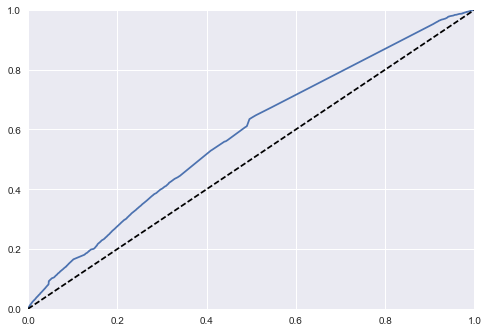

In [55]:
plt.plot(fpr, tpr)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')